In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Neural Net libraries. 
# I installed the live version of lasagne, theano, and nolearn directly from git. Follow this instructions here:
# https://github.com/dnouri/nolearn
from lasagne import layers
from lasagne import nonlinearities
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

# Function to print all pandas rows
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', len(x.columns))
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [2]:
data = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/train.csv")
test = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/test.csv")


In [3]:
# Big Picture of Data
print "Train Data:"
print data.shape
print data.columns.values
print "Test Data:"
print test.shape
print test.columns.values


Train Data:
(878049, 9)
['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y']
Test Data:
(884262, 7)
['Id' 'Dates' 'DayOfWeek' 'PdDistrict' 'Address' 'X' 'Y']


In [4]:
# Extract new features here because it's easier in Pandas than NumPy
def build_features(data):
    data['DateTime'] = pd.to_datetime(data['Dates'])
    date_vector = data['DateTime'].dt.date
    data['DateDiff'] = (date_vector - date_vector.min()) / np.timedelta64(1, 'D')
    data['Year'] = pd.DatetimeIndex(data['DateTime']).year
    data['Month'] = pd.DatetimeIndex(data['DateTime']).month
    data['Day'] = pd.DatetimeIndex(data['DateTime']).day
    data['Hour'] = pd.DatetimeIndex(data['DateTime']).hour
    data['SecondsDelta'] = (data.DateTime - pd.Timestamp('2013-01-01')) / np.timedelta64(1,'s')
    data['Weekend'] = (data.DayOfWeek == "Saturday") | (data.DayOfWeek == "Sunday")
    years = pd.get_dummies(data.Year)
    years.columns = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
    months = pd.get_dummies(data.Month)
    months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days = pd.get_dummies(data.Day)
    days.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
    daysofweek = pd.get_dummies(data.DayOfWeek)
    hours = pd.get_dummies(data.Hour)
    hours.columns = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM',
                     '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
                     '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
                     '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']
    districts = pd.get_dummies(data.PdDistrict)
    new_data = pd.concat([data, years, months, days, daysofweek, hours, districts], axis=1)
    return new_data


data = build_features(data)
test = build_features(test)

#print data.columns.values


In [5]:
#Generate location dummies (try 3 and 4 decimals)
XR3 = data['X'].round(decimals=3).apply(str)
YR3 = data['Y'].round(decimals=3).apply(str)
#XR4 = data['X'].round(decimals=4).apply(str)
#YR4 = data['Y'].round(decimals=4).apply(str)
data_XR3s = pd.get_dummies(XR3)
data_YR3s = pd.get_dummies(YR3)    
#data_XR4s = pd.get_dummies(XR4)
#data_YR4s = pd.get_dummies(YR4)
XR3 = test['X'].round(decimals=3).apply(str)
YR3 = test['Y'].round(decimals=3).apply(str)
#XR4 = test['X'].round(decimals=4).apply(str)
#YR4 = test['Y'].round(decimals=4).apply(str)
test_XR3s = pd.get_dummies(XR3)
test_YR3s = pd.get_dummies(YR3)    
#test_XR4s = pd.get_dummies(XR4)
#test_YR4s = pd.get_dummies(YR4)    

#Subset the test ot only include ones in train
#overlapX = list(set(list(test_XR4s)) & set(list(data_XR4s)))
#overlapY = list(set(list(test_YR4s)) & set(list(data_YR4s)))

test_XR3s = test_XR3s[list(data_XR3s)]
test_YR3s = test_YR3s[list(data_YR3s)]
#test_XR4s = test_XR4s[overlapX]
#test_YR4s = test_YR4s[overlapY]

print data_XR3s.shape
print data_YR3s.shape
#print data_XR4s.shape
#print data_YR4s.shape
print
print test_XR3s.shape
print test_YR3s.shape
#print test_XR4s.shape
#print test_YR4s.shape



(878049, 147)
(878049, 107)

(884262, 147)
(884262, 107)


In [1]:
# Separate labels
train_labels = data.Category

# Create integer labels
panda_labels = pd.Categorical(data.Category).codes
train_labels_int = np.array(panda_labels).astype(np.int32)

# Drop Category, Descript and Resolution columns since they are not in the test set.
# Drop non-numerics too - they are accounted for as dummy variables.
train_data = data.drop(['Category', 'Descript', 'Resolution', 'DateTime', 'Dates', 'PdDistrict', 'Address', 'DayOfWeek'], axis=1)
train_data.Weekend = train_data.Weekend * 1
train_names = train_data.columns.values.tolist()

test_data = test.drop(['DateTime', 'Dates', 'PdDistrict', 'Address', 'DayOfWeek'], axis=1)
test_data.Weekend = test_data.Weekend * 1
test_names = test_data.columns.values.tolist()

#print_full(train_data.head(5))
#print_full(test_data.head(5))

#print_full(pd.DataFrame(train_data.dtypes))

NameError: name 'data' is not defined

In [7]:
#TODO 
#data_address_dummies = pd.get_dummies(data.Address,sparse=True)
#test_address_dummies = pd.get_dummies(test.Address,sparse=True

In [8]:
#TODO 
#print pd.concat([data, pd.get_dummies(data.PdDistrict, prefix="PdDistrict")], axis=1)
# Let's create dummy variables for any address with over 100 events.
#print len(address_counts)
#print len(address_counts[address_counts > 100])
#address_list.columns.values = ["Address"]
#print pd.DataFrame(address_list).columns.values
#print data.columns.values
#print address_list
#top_address['temp'] = 1
#bottom_address = pd.merge(data, top_address, how='left', on=['Address'])


#address_counts = data["Address"].value_counts()
#address_list = pd.Series(address_counts[address_counts > 100].index).to_frame("Address")
#top_address = pd.merge(data, address_list, how='inner', on=['Address'])
#print data.shape
#print result.shape
#print bottom_address.shape

#address_counts[address_counts > 100].index.values



In [9]:
# Lasagne works off of Theano instead of Numpy
#print data.Category
#train_data = np.array(data[['X','Y','Year','Month','Day','Hour','DayOfYear']].values)
#train_data = np.array(data_features)

#panda_labels = pd.Categorical(data.Category).labels
#train_labels = np.array(panda_labels).astype(np.int32)
#print train_labels
#print train_data.groupby(level=0).first()
#print train_data.index.get_duplicates()
#print train_data.shape



In [10]:
# Create random dev sample so we can see how that accuracy compares to our Kaggle results
# np.random.seed(100)

# Pick 10% of rows for dev
# rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

# dev = data.ix[rows]
# train = data.drop(rows)

# print train.shape
# print dev.shape
# print test.shape


features = [
 'X', 'Y', 'DateDiff', 'Year', 'Month', 'Day', 'Hour',
 'SecondsDelta', 'Weekend', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
 '2010', '2011', '2012', '2013', '2014', '2015', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '1', '2', '3', '4', '5', '6', '7', '8',
 '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
 '24', '25', '26', '27', '28', '29', '30', '31', 'Friday', 'Monday', 'Saturday',
 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM',
 '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM',
 '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL',
 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL',
 'TENDERLOIN']

In [12]:
# Convert to numpy
#features = ['X', 'Y'] #???? | ???? | 2.69680 | 0.1871
#features = ['X', 'Y', 'DateDiff'] #2.73877 | 2.69913 | 2.69680 | 0.199
#features = ['X', 'Y', 'DateDiff', 'Year', 'Month', 'Day', 'Hour', 'Weekend'] #2.73866 | 2.69914 || 0.199
#features = ['X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'Weekend'] #2.73870
#features = ['Year', 'Month', 'Day', 'Hour', 'Weekend'] #2.73867
#features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',] # 2.70496
#2.64560 | 2.62009 | 0.174%
#features = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
#2.71693|||0.20055
#[(200,10) = 0.231704608741]
#[(500,20) = 0.240513912094]
#features = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', 'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',  '24', '25', '26', '27', '28', '29', '30', '31', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM',  '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
#features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
features = ['Jan','Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']


#np_train_data = np.array(train_data[features])
#np_train_data = np.array(pd.concat([data_XRs, data_YRs], axis=1))
#np_train_data = np.array(pd.concat([train_data[features], data_XRs, data_YRs], axis=1))
# Need to drop any "test" coordinate features that are not in "train". We accept this as a limitation.

np_train_data = np.array(pd.concat([train_data[features], (data.Year < 2006) * 1, (data.Year < 2008) * 1, (data.Year < 2010) * 1, data_XR3s, data_YR3s], axis=1))
np_test_data = np.array(pd.concat([test_data[features], (test.Year < 2006) * 1, (test.Year < 2008) * 1, (test.Year < 2010) * 1, test_XR3s[list(data_XR3s)], test_YR3s[list(data_YR3s)]], axis=1))
#np_train_data4 = np.array(pd.concat([train_data[features], (data.Year < 2006) * 1, (data.Year < 2008) * 1, (data.Year < 2010) * 1, data_XR4s, data_YR4s], axis=1))


print np_train_data.shape
print np_test_data.shape

(878049, 299)
(884262, 299)


In [22]:
# features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
# The accuracy is: 0.293386815542
# Should run again stopping early @ 65 for better results
num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # automatically calculate the number of featrues
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=65,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
net1.fit(np_train_data, train_labels_int)

(878049, 299)
(878049,)
# Neural Network with 169539 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      299
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.62687       2.62683      1.00001      0.22451  32.22s
      2       2.52016       2.59829      0.96993      0.22837  29.78s
      3       2.49604       2.58270      0.96645      0.23156  30.13s
      4       2.48211       2.57427      0.96420      0.23356  29.14s
      5       2.47273       2.56963      0.96229      0.23478  27.44s
      6       2.46537       2.56693      0.96044      0.23686  26.94s
      7       2.45904       2.56508      0.95866      0.23838  27.37s
      8       2.45332       2.56359      0.95699      0.24026  27.99s
      9       2.44803       2.56212      0.95547      0.24148  27.87s
     10       2.44309       2.56051

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc190>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 299),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=65, more_params={},
     objective=<function objective at 0x10c1c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c0e5c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x11993ee18>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x11ac681b8>],
     output_nonlinearity=<function softmax at 0x10b79f398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit object

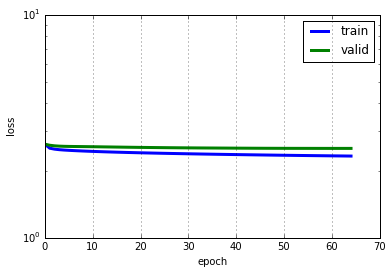

In [23]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-0, 1e1)
plt.yscale("log")
plt.show()


In [46]:
train_pred = net3.predict(np_train_data)
print(classification_report(train_labels_int, train_pred))
print 'The accuracy is:', accuracy_score(train_labels_int, train_pred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1513
          1       0.21      0.17      0.19     76876
          2       0.00      0.00      0.00       406
          3       0.00      0.00      0.00       289
          4       0.24      0.06      0.10     36755
          5       0.42      0.01      0.01      4320
          6       0.00      0.00      0.00      2268
          7       0.29      0.51      0.37     53971
          8       0.00      0.00      0.00      4280
          9       0.00      0.00      0.00      1166
         10       0.00      0.00      0.00       256
         11       0.00      0.00      0.00       491
         12       0.18      0.04      0.06     10609
         13       0.21      0.00      0.01     16679
         14       0.00      0.00      0.00       146
         15       0.00      0.00      0.00      2341
         16       0.33      0.67      0.45    174900
         17       0.34      0.02      0.03   

In [53]:
def create_submission(preds):
    labels = ["Id",
                "ARSON",
                "ASSAULT",
                "BAD CHECKS",
                "BRIBERY",
                "BURGLARY",
                "DISORDERLY CONDUCT",
                "DRIVING UNDER THE INFLUENCE",
                "DRUG/NARCOTIC",
                "DRUNKENNESS",
                "EMBEZZLEMENT",
                "EXTORTION",
                "FAMILY OFFENSES",
                "FORGERY/COUNTERFEITING",
                "FRAUD",
                "GAMBLING",
                "KIDNAPPING",
                "LARCENY/THEFT",
                "LIQUOR LAWS",
                "LOITERING",
                "MISSING PERSON",
                "NON-CRIMINAL",
                "OTHER OFFENSES",
                "PORNOGRAPHY/OBSCENE MAT",
                "PROSTITUTION",
                "RECOVERED VEHICLE",
                "ROBBERY",
                "RUNAWAY",
                "SECONDARY CODES",
                "SEX OFFENSES FORCIBLE",
                "SEX OFFENSES NON FORCIBLE",
                "STOLEN PROPERTY",
                "SUICIDE",
                "SUSPICIOUS OCC",
                "TREA",
                "TRESPASS",
                "VANDALISM",
                "VEHICLE THEFT",
                "WARRANTS",
                "WEAPON LAWS"
              ]
    head_str = ','.join(labels)

    num_cats = len(labels)
    
    # Make a dummy row to append to
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    
    results = np.column_stack((ids, preds))

    # Write results to csv
    str_fmt = "%d"
    for i in range(0,39):
        str_fmt += ",%f"
    np.savetxt('Sample_NN_Deep2.csv', results, fmt=str_fmt, delimiter=',', header=head_str, comments='')

    #return results

In [54]:
# Now that we've done this, let's run the KNN on the full train, apply to the test, then format.
#KNNmodel = KNeighborsClassifier(n_neighbors=1)
#KNNmodel.fit(full_data, full_labels)
#dev_predict = KNNmodel.predict_proba(test_data).astype(int)

print np_train_data.shape
print np_test_data.shape
test_proba = net1.predict_proba(np_test_data)


(878049, 299)
(884262, 299)


In [55]:
results = create_submission(test_proba)

In [165]:
print results.shape
#print results[0:2]
print str_fmt
print len(str_fmt)/3


(884262, 40)
%d %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f
40


In [28]:
# Tried a more complicated net with layers... still doing the same thing.
num_features = np_train_data.shape[1]

net2 = NeuralNet(
    layers=[  # more layers
        ('input', layers.InputLayer),
        ('dense0', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('dense1', layers.DenseLayer),
        ('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    dense0_num_units=500,  # number of units in hidden layer
    dropout_p=0.5,  # randomly disconect a number of notes to help preven overfitting
    dense1_num_units=500,  # number of units in hidden layer
    output_num_units=39,  # 39 target values
    output_nonlinearity=nonlinearities.softmax,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

net2.fit(np_train_data, train_labels_int)


# Neural Network with 420039 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      500
  2  dropout     500
  3  dense1      500
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.49865       2.65078      0.94261      0.21992  84.06s
      2       2.43557       2.60976      0.93326      0.23235  82.84s
      3       2.41412       2.58342      0.93447      0.23864  84.63s
      4       2.40060       2.56654      0.93535      0.24160  87.63s
      5       2.39060       2.55583      0.93535      0.24474  88.61s
      6       2.38290       2.53963      0.93829      0.24722  86.20s
      7       2.37709       2.52743      0.94051      0.24763  89.13s
      8       2.37068       2.52606      0.93849      0.24882  94.16s
      9       2.36634       2.52168      0.93840      0.24982  86.55s
     10     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc190>,
     custom_score=None, dense0_num_units=500, dense1_num_units=500,
     dropout_p=0.5, input_shape=(None, 299),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c1c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c0e5c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x11ac25200>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x11abf8830>],
    

In [45]:
# Tried a more complicated net with layers... still doing the same thing.
num_features = np_train_data.shape[1]

net3 = NeuralNet(
    layers=[  # more layers
        ('input', layers.InputLayer),
        ('dense0', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('dense1', layers.DenseLayer),
        ('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    dense0_num_units=500,  # number of units in hidden layer
    dropout_p=0.5,  # randomly disconect a number of notes to help preven overfitting
    dense1_num_units=500,  # number of units in hidden layer
    output_num_units=39,  # 39 target values
    output_nonlinearity=nonlinearities.softmax,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=40,  # we want to train this many epochs
    verbose=1,
    )

net3.fit(np_train_data, train_labels_int)


# Neural Network with 420039 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      500
  2  dropout     500
  3  dense1      500
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.49755       2.65711      0.93995      0.22395  83.58s
      2       2.43409       2.60991      0.93263      0.23222  83.18s
      3       2.41343       2.58174      0.93480      0.23777  83.77s
      4       2.40078       2.56049      0.93763      0.24299  84.11s
      5       2.39081       2.55195      0.93686      0.24226  84.18s
      6       2.38352       2.53489      0.94028      0.24644  84.45s
      7       2.37662       2.52921      0.93967      0.24769  84.78s
      8       2.37154       2.52130      0.94060      0.24904  84.80s
      9       2.36625       2.51491      0.94089      0.24977  84.96s
     10     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc190>,
     custom_score=None, dense0_num_units=500, dense1_num_units=500,
     dropout_p=0.5, input_shape=(None, 299),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=40, more_params={},
     objective=<function objective at 0x10c1c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c0e5c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x127685fc8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x12795d200>],
     

In [56]:
# Tried a more complicated net with layers... still doing the same thing.
num_features = np_train_data.shape[1]

net4 = NeuralNet(
    layers=[  # more layers
        ('input', layers.InputLayer),
        ('dense0', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('dense1', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        ('dense2', layers.DenseLayer),
        ('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    dense0_num_units=500,  # number of units in hidden layer
    dropout_p=0.5,  # Not sure what this does.....
    dense1_num_units=500,  # number of units in hidden layer
    dropout2_p=0.5,  # Not sure what this does.....
    dense2_num_units=500,  # number of units in hidden layer
    output_num_units=39,  # 39 target values
    output_nonlinearity=nonlinearities.softmax,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=40,  # we want to train this many epochs
    verbose=1,
    )

net4.fit(np_train_data, train_labels_int)


# Neural Network with 670539 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input        299
  1  dense0       500
  2  dropout      500
  3  dense1       500
  4  dropout2     500
  5  dense2       500
  6  output        39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
      1       2.51606       2.62653      0.95794      0.22004  133.23s
      2       2.44882       2.59233      0.94464      0.23085  130.09s
      3       2.42730       2.57093      0.94413      0.23736  130.94s
      4       2.41481       2.56277      0.94226      0.23933  131.46s
      5       2.40572       2.55340      0.94216      0.23926  136.97s
      6       2.39905       2.53952      0.94469      0.24458  134.14s
      7       2.39298       2.53399      0.94435      0.24412  132.86s
      8       2.38778       2.52930      0.94405      0.24502  132.63s
      9       2.38282 

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc190>,
     custom_score=None, dense0_num_units=500, dense1_num_units=500,
     dense2_num_units=500, dropout2_p=0.5, dropout_p=0.5,
     input_shape=(None, 299),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout2', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=40, more_params={},
     objective=<function objective at 0x10c1c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c0e5c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog

In [38]:
#### TEST WITH DIFFERENT NODE NUMBERS
#### >600 seems mildly better

# Tried a more complicated net with layers... still doing the same thing.
num_features = np_train_data.shape[1]
netlist = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

nets = {}
for x, y in enumerate(netlist):
    print "Loop: " + str(x) + " Net: " + str(y)
    this_net = NeuralNet(
        layers=[  # more layers
            ('input', layers.InputLayer),
            ('dense0', layers.DenseLayer),
            ('dropout', layers.DropoutLayer),
            ('dense1', layers.DenseLayer),
            ('output', layers.DenseLayer)
        ],
        # layer parameters:
        input_shape=(None, num_features),  # 3 input pixels per batch
        dense0_num_units= y,  # number of units in hidden layer
        dropout_p=0.5,  # Not sure what this does.....
        dense1_num_units= y,  # number of units in hidden layer
        output_num_units=39,  # 39 target values
        output_nonlinearity=nonlinearities.softmax,

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.02,
        update_momentum=0.9,

        regression=False,  # flag to indicate we're not dealing with regression problem
        max_epochs=5,  # we want to train this many epochs
        verbose=1,
        )

    this_net.fit(np_train_data, train_labels_int)    
#print nets
    


Loop: 0 Net: 100
# Neural Network with 44039 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      100
  2  dropout     100
  3  dense1      100
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.52787       2.63137      0.96067      0.22331  15.39s
      2       2.46498       2.60272      0.94708      0.22908  15.11s
      3       2.44846       2.57903      0.94937      0.23337  15.64s
      4       2.43978       2.57073      0.94906      0.23660  15.20s
      5       2.43432       2.55846      0.95148      0.23976  14.53s
Loop: 1 Net: 200
# Neural Network with 108039 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      200
  2  dropout     200
  3  dense1      200
  4  output       39

  epoch    train loss    valid loss   

In [39]:
#### TEST WITH DIFFERENT DROPOUT PERCENTAGES
#### Use 600 which did pretty good above.
#### 0.3 did the best

# Tried a more complicated net with layers... still doing the same thing.
num_features = np_train_data.shape[1]
netlist = [.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99]

nets = {}
for x, y in enumerate(netlist):
    print "Loop: " + str(x) + " Net: " + str(y)
    this_net = NeuralNet(
        layers=[  # more layers
            ('input', layers.InputLayer),
            ('dense0', layers.DenseLayer),
            ('dropout', layers.DropoutLayer),
            ('dense1', layers.DenseLayer),
            ('output', layers.DenseLayer)
        ],
        # layer parameters:
        input_shape=(None, num_features),  # 3 input pixels per batch
        dense0_num_units= 600,  # number of units in hidden layer
        dropout_p=y,  # Not sure what this does.....
        dense1_num_units= 600,  # number of units in hidden layer
        output_num_units=39,  # 39 target values
        output_nonlinearity=nonlinearities.softmax,

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.02,
        update_momentum=0.9,

        regression=False,  # flag to indicate we're not dealing with regression problem
        max_epochs=5,  # we want to train this many epochs
        verbose=1,
        )

    this_net.fit(np_train_data, train_labels_int)    
#print nets
    


Loop: 0 Net: 0.01
# Neural Network with 564039 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      600
  2  dropout     600
  3  dense1      600
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
      1       2.47409       2.62851      0.94125      0.22789  108.57s
      2       2.40458       2.59963      0.92497      0.23680  790.10s
      3       2.37736       2.57643      0.92273      0.23843  103.52s
      4       2.35790       2.56026      0.92096      0.24065  111.53s
      5       2.34173       2.54856      0.91884      0.24322  106.94s
Loop: 1 Net: 0.1
# Neural Network with 564039 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      600
  2  dropout     600
  3  dense1      600
  4  output       39

  epoch    train loss    valid

In [41]:
#### TEST WITH DIFFERENT LAYER SIZEZ
#### Use 600 which did pretty good above.
#### Use 0.3 did the best
#### Iterate the 2nd Layer 10,20,50, 100s

# Tried a more complicated net with layers... still doing the same thing.
num_features = np_train_data.shape[1]
netlist = [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]

nets = {}
for x, y in enumerate(netlist):
    print "Loop: " + str(x) + " Net: " + str(y)
    this_net = NeuralNet(
        layers=[  # more layers
            ('input', layers.InputLayer),
            ('dense0', layers.DenseLayer),
            ('dropout', layers.DropoutLayer),
            ('dense1', layers.DenseLayer),
            ('output', layers.DenseLayer)
        ],
        # layer parameters:
        input_shape=(None, num_features),  # 3 input pixels per batch
        dense0_num_units= 600,  # number of units in hidden layer
        dropout_p= 0.3,  # Not sure what this does.....
        dense1_num_units= y,  # number of units in hidden layer
        output_num_units=39,  # 39 target values
        output_nonlinearity=nonlinearities.softmax,

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.02,
        update_momentum=0.9,

        regression=False,  # flag to indicate we're not dealing with regression problem
        max_epochs=5,  # we want to train this many epochs
        verbose=1,
        )

    this_net.fit(np_train_data, train_labels_int)    
#print nets
    


Loop: 0 Net: 10
# Neural Network with 186439 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      600
  2  dropout     600
  3  dense1       10
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.51448       2.68829      0.93535      0.21206  45.85s
      2       2.44747       2.64082      0.92678      0.22623  46.33s
      3       2.42075       2.59907      0.93139      0.23785  47.36s
      4       2.40447       2.57744      0.93289      0.24148  47.61s
      5       2.39243       2.56273      0.93355      0.24474  48.04s
Loop: 1 Net: 20
# Neural Network with 192839 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      600
  2  dropout     600
  3  dense1       20
  4  output       39

  epoch    train loss    valid loss    

____
____
____

Old code below here
____
____
____


In [109]:
np_train_data = np.array(pd.concat([data_XRs, data_YRs], axis=1))
num_features = np_train_data.shape[1]
#The accuracy is: 0.26692018327

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 254)
(878049,)
# Neural Network with 147039 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      254
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.67321       2.66736      1.00219      0.20197  24.90s
      2       2.56639       2.64605      0.96990      0.20978  24.59s
      3       2.54176       2.63234      0.96559      0.21508  24.00s
      4       2.52726       2.62335      0.96337      0.21664  24.68s
      5       2.51784       2.61697      0.96212      0.21816  24.39s
      6       2.51080       2.61196      0.96127      0.22045  23.91s
      7       2.50493       2.60775      0.96057      0.22372  23.92s
      8       2.49969       2.60389      0.95998      0.22694  23.90s
      9       2.49486       2.60038      0.95942      0.22709  24.10s
     10       2.49034       2.59712

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc1d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc150>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 254),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c3c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c1e2c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x112c910e0>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x113a6a950>],
     output_nonlinearity=<function softmax at 0x10c09c398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit objec

In [120]:
# features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
# The accuracy is: 0.283077595897
# Should run again stopping early @ 77 for better results
num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 295)
(878049,)
# Neural Network with 167539 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      295
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.63132       2.62853      1.00106      0.22558  29.17s
      2       2.52393       2.60553      0.96868      0.22639  28.61s
      3       2.49870       2.59233      0.96388      0.22789  31.51s
      4       2.48395       2.58444      0.96112      0.22916  26.67s
      5       2.47430       2.57896      0.95942      0.23070  27.25s
      6       2.46697       2.57455      0.95822      0.23279  28.06s
      7       2.46080       2.57073      0.95724      0.23409  27.99s
      8       2.45531       2.56732      0.95637      0.23547  27.81s
      9       2.45030       2.56427      0.95556      0.23653  27.60s
     10       2.44568       2.56148

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc1d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc150>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 295),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c3c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c1e2c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x114963878>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x114aeb710>],
     output_nonlinearity=<function softmax at 0x10c09c398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit objec

(878049, 296)
(884262, 308)


In [193]:
# features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
# np_train_data = np.array(pd.concat([train_data[features], (data.Year < 2008) * 1, data_XRs, data_YRs], axis=1))

num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 296)
(878049,)
# Neural Network with 168039 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      296
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.62875       2.62633      1.00092      0.22510  29.49s
      2       2.52224       2.60240      0.96920      0.22908  29.07s
      3       2.49736       2.58764      0.96511      0.23085  30.53s
      4       2.48292       2.57807      0.96309      0.23283  32.36s
      5       2.47333       2.57122      0.96193      0.23478  30.58s
      6       2.46596       2.56577      0.96110      0.23661  29.43s
      7       2.45976       2.56136      0.96033      0.23805  27.92s
      8       2.45424       2.55749      0.95963      0.23935  27.95s
      9       2.44921       2.55418      0.95890      0.24044  28.26s
     10       2.44456       2.55124

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc1d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc150>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 296),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c3c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c1e2c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x114b3a758>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x1171d6290>],
     output_nonlinearity=<function softmax at 0x10c09c398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit objec

In [197]:
# features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
# np_train_data = np.array(pd.concat([train_data[features], (data.Year < 2008) * 1, (data.Year < 2010) * 1, data_XRs, data_YRs], axis=1))
num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 297)
(878049,)
# Neural Network with 168539 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      297
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.62592       2.62294      1.00114      0.22713  29.77s
      2       2.51960       2.59705      0.97018      0.22995  31.28s
      3       2.49565       2.58266      0.96631      0.23189  30.75s
      4       2.48211       2.57427      0.96420      0.23377  32.86s
      5       2.47307       2.56915      0.96261      0.23547  28.59s
      6       2.46605       2.56581      0.96112      0.23733  28.48s
      7       2.46002       2.56332      0.95970      0.23939  29.78s
      8       2.45459       2.56129      0.95834      0.24093  28.83s
      9       2.44958       2.55955      0.95703      0.24215  28.69s
     10       2.44492       2.55793

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc1d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc150>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 297),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c3c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c1e2c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x12193a128>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x121938098>],
     output_nonlinearity=<function softmax at 0x10c09c398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit objec

In [199]:
# features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
# np_train_data = np.array(pd.concat([train_data[features], (data.Year < 2006) * 1, (data.Year < 2008) * 1, (data.Year < 2010) * 1, data_XRs, data_YRs], axis=1))
num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 298)
(878049,)
# Neural Network with 169039 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      298
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.62809       2.62996      0.99929      0.22293  29.86s
      2       2.52001       2.60081      0.96893      0.22731  31.13s
      3       2.49587       2.58352      0.96607      0.23178  31.61s
      4       2.48171       2.57370      0.96426      0.23485  35.16s
      5       2.47211       2.56818      0.96259      0.23673  29.39s
      6       2.46465       2.56479      0.96096      0.23867  28.68s
      7       2.45834       2.56239      0.95939      0.23985  29.94s
      8       2.45272       2.56042      0.95794      0.24137  29.30s
      9       2.44761       2.55861      0.95662      0.24299  29.00s
     10       2.44287       2.55680

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc1d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc150>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 298),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c3c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c1e2c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x11c653fc8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x11c659cf8>],
     output_nonlinearity=<function softmax at 0x10c09c398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit objec

In [13]:
# features = ['Jan','Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
# np_train_data = np.array(pd.concat([train_data[features], (data.Year < 2006) * 1, (data.Year < 2008) * 1, (data.Year < 2010) * 1, data_XR3s, data_YR3s], axis=1))
# The accuracy is: 0.293386815542
# Should run again stopping early @ 65 for better results
num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 299)
(878049,)
# Neural Network with 169539 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      299
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.62886       2.63097      0.99920      0.22816  30.40s
      2       2.52144       2.60047      0.96961      0.23028  28.56s
      3       2.49645       2.58330      0.96638      0.23256  27.83s
      4       2.48195       2.57386      0.96429      0.23344  27.19s
      5       2.47231       2.56853      0.96254      0.23579  26.93s
      6       2.46488       2.56516      0.96091      0.23799  28.16s
      7       2.45856       2.56277      0.95934      0.23993  27.66s
      8       2.45292       2.56084      0.95786      0.24158  27.92s
      9       2.44778       2.55915      0.95648      0.24310  27.23s
     10       2.44303       2.55763

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c1cc190>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 299),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c1c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c0e5c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x10c110b90>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x118cca050>],
     output_nonlinearity=<function softmax at 0x10b79f398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit objec